# AI Alpha

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

Looking in links: https://files.pythonhosted.org/
Processing /Users/yuki/Library/Caches/pip/wheels/dc/58/9b/5bc164e8566cf7c1658d9e4418540b2b12c201828666c6faf4/alphalens-0.3.6-cp36-none-any.whl


  Attempting uninstall: alphalens
    Found existing installation: alphalens 0.3.2
    Uninstalling alphalens-0.3.2:
      Successfully uninstalled alphalens-0.3.2


In [96]:
import helper
import unit_test

import cvxpy as cvx
import numpy as np
import pandas as pd
import time

from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Data Bundle

In [3]:
import os
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'data', 'zipline')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], helper.EOD_BUNDLE_NAME)
bundles.register(helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


In [4]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(helper.EOD_BUNDLE_NAME)
engine = helper.build_pipeline_engine(bundle_data, trading_calendar)

In [5]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

## Get Returns

In [6]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

In [7]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [8]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.00843652,0.01423027,0.02670202,0.00714639,0.00000000,0.00199434,0.00416541,0.00164769,-0.00712736,-0.00581846,...,-0.00183775,-0.00561865,0.00546091,-0.00404361,-0.01395259,0.00000000,0.01245693,-0.00018145,-0.01045802,0.00000000
2011-01-10 00:00:00+00:00,-0.00417428,0.00619534,0.00743543,0.01885158,0.00000000,-0.00571429,-0.00889600,-0.00885384,0.02871411,0.00292626,...,0.00094687,0.00781438,-0.00608100,0.01046585,0.00973303,0.00000000,0.00143979,0.00778351,-0.01794496,0.00000000
2011-01-11 00:00:00+00:00,-0.00188630,-0.04364361,-0.00592730,-0.00236744,0.00000000,0.00978303,-0.00206747,0.01371668,0.00060680,0.00875316,...,0.00131385,0.01017933,0.00744242,0.00735141,0.00611644,0.00000000,-0.00646974,0.03567570,0.00746728,0.00000000
2011-01-12 00:00:00+00:00,0.01725375,-0.00823708,0.01338721,0.00813289,0.00000000,-0.00597922,-0.00101061,0.02296913,0.01795027,0.00025710,...,0.00498609,0.01566621,0.01176334,0.02718194,0.00438630,0.00000000,0.00263106,0.01474083,-0.01190269,0.00000000
2011-01-13 00:00:00+00:00,-0.00455851,0.00095465,0.00303109,0.00365656,0.00000000,0.01492537,-0.00445119,-0.00040011,-0.00571905,-0.00501221,...,0.03049927,-0.00321668,0.00169383,0.00054651,-0.01823475,0.00000000,-0.00508430,-0.00466453,-0.00917796,0.00000000
2011-01-14 00:00:00+00:00,0.00343886,-0.00915594,0.00302193,0.00810620,0.00000000,0.00139452,-0.01011076,0.00259000,0.01228280,0.01982692,...,0.02660653,0.02589425,0.01474258,-0.00028748,0.02649446,0.00000000,-0.02166101,0.00594885,0.03317747,0.00000000
2011-01-18 00:00:00+00:00,0.03425353,-0.06208490,-0.00428562,-0.02247419,0.00000000,0.02088872,0.00662116,0.00699843,0.01154188,0.03264518,...,0.00167843,0.00250133,0.01116324,0.01158879,0.00604402,0.00000000,0.02945339,0.00699753,-0.00853448,0.00000000
2011-01-19 00:00:00+00:00,-0.01022379,-0.00892857,0.00875376,-0.00531448,0.00000000,-0.01714410,0.00275342,-0.00296182,-0.00789936,-0.02057462,...,-0.01483416,-0.02358990,-0.00596800,-0.01989880,-0.01284667,0.00000000,0.00081838,-0.00409759,-0.01843318,0.00000000
2011-01-20 00:00:00+00:00,-0.00849568,0.02195299,-0.00473189,-0.01818900,0.00000000,0.00479450,0.01332249,0.01871257,-0.01238573,-0.00281761,...,-0.02451226,0.00774353,-0.00626137,-0.00084112,-0.03379775,0.00000000,-0.01318157,-0.00161165,-0.00797236,0.00000000
2011-01-21 00:00:00+00:00,0.00787281,-0.04103759,0.00554409,-0.01791080,0.00000000,0.01064197,-0.00085307,-0.00195169,-0.00656913,-0.00411277,...,0.00000000,0.00061472,0.01582494,-0.00304798,-0.00087153,0.00000000,-0.00759032,0.00932467,0.02402000,0.00000000


# Statistical Risk Model

## PCA

In [9]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca


In [10]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[-0.04316847, -0.05874471, -0.03433256, ..., -0.03843904,
        -0.06092493, -0.01367163],
       [ 0.01955111,  0.19637679,  0.03451503, ...,  0.01749339,
        -0.01044197,  0.01892192],
       [-0.00993375,  0.07868756,  0.01133839, ..., -0.0157519 ,
         0.01261759,  0.01867875],
       ...,
       [-0.01174265,  0.01398085,  0.05143999, ...,  0.04125323,
         0.0035229 ,  0.03682367],
       [ 0.00526925, -0.04680674,  0.05716915, ...,  0.00671842,
        -0.02193923,  0.00833979],
       [-0.00535269, -0.01599057,  0.08414961, ..., -0.01540844,
         0.02188794,  0.01500221]])

In [11]:
pca.components_.shape

(20, 490)

<BarContainer object of 20 artists>

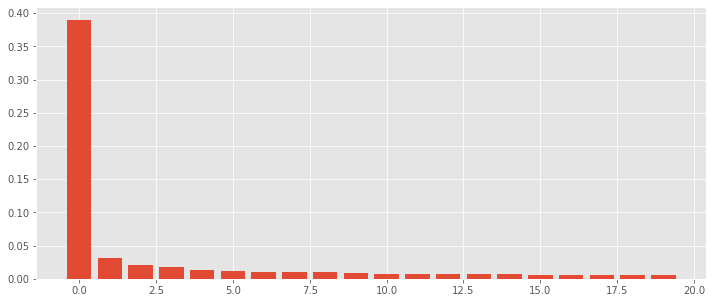

In [12]:
plt.figure(figsize=(12,5))
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

## Factor Betas

In [13]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """Get the factor betas from the PCA model."""
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    factor_betas = pd.DataFrame(pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)
    
    return factor_betas


In [14]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.04316847,0.01955111,-0.00993375,0.01054038,-0.01819821,0.01074517,0.00112915,0.03973914,-0.01380519,0.01273651,-0.02384028,-0.00141663,0.02099338,0.03460997,-0.03048936,0.03360635,-0.01142920,-0.01174265,0.00526925,-0.00535269
Equity(1 [AAL]),-0.05874471,0.19637679,0.07868756,0.08209582,0.34847826,-0.13808246,0.07129285,0.10524788,-0.04588957,-0.08547793,0.00328328,0.10534284,0.06721603,-0.04405955,-0.02231617,0.01726309,-0.03310836,0.01398085,-0.04680674,-0.01599057
Equity(2 [AAP]),-0.03433256,0.03451503,0.01133839,-0.02543666,-0.00817211,-0.01318319,-0.06095238,0.00654915,-0.03265404,-0.01351522,0.02896685,0.03836520,-0.04960451,-0.00524576,-0.02196994,0.02976718,-0.01163585,0.05143999,0.05716915,0.08414961
Equity(3 [AAPL]),-0.03409988,-0.00139319,0.03946700,-0.01721303,-0.03046983,-0.01757067,0.02325117,0.01142987,-0.02656849,-0.00771904,0.02686350,0.00731877,0.00481832,0.01288623,0.05256513,-0.07344470,-0.03179158,0.09079374,-0.01118851,0.04291373
Equity(4 [ABBV]),-0.01803099,0.02568151,0.00435183,-0.07078179,0.01319937,0.05427710,-0.01567842,0.04046172,-0.01245487,-0.03515086,-0.05132433,-0.04041614,-0.05120320,-0.01858166,-0.01126857,-0.04200714,0.01588559,0.04598554,0.01599288,0.06587978
Equity(5 [ABC]),-0.02890016,0.03259161,-0.00742074,-0.03355183,-0.01152149,0.02648421,0.01084965,-0.00570393,0.01354800,-0.02967931,-0.03161765,0.01715152,-0.00304998,0.02635564,0.00787900,0.00833106,-0.01834622,-0.01391370,0.01062042,-0.02739565
Equity(6 [ABT]),-0.02905740,0.02977821,-0.02970871,-0.03574263,-0.01157351,0.06020073,-0.02004042,0.04098522,-0.01803987,-0.00620785,-0.03157790,-0.02308041,-0.01436789,-0.00054254,-0.01932887,0.01428819,-0.03938064,0.01071208,0.01712006,0.00210689
Equity(7 [ACN]),-0.04337745,0.00256907,0.00413229,-0.00349265,-0.05430743,0.00537434,0.00277996,0.03043220,-0.01880168,-0.00178336,-0.03540357,-0.01093170,0.02611241,-0.01233115,0.00322097,0.01770011,-0.00285123,-0.01235874,-0.01400935,-0.03855653
Equity(8 [ADBE]),-0.04730285,0.02661175,0.03057072,-0.02114690,-0.04838794,-0.00708698,0.00743385,0.00747095,0.01487098,-0.00153422,-0.01238383,-0.00667442,0.03500718,-0.04336579,0.01060255,-0.00637875,0.02127339,-0.03638845,0.00126811,-0.04844555
Equity(9 [ADI]),-0.04712287,-0.00381150,0.05600847,-0.01553775,-0.06946243,-0.00560418,0.10070366,0.06307694,0.00160769,0.01912993,0.01101680,0.00348733,-0.05465749,-0.04223802,-0.00014275,-0.04843166,0.00374282,0.04583322,0.01483456,0.00768623


## Factor Returns

In [15]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """Get the factor returns from the PCA model."""
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    factor_returns = pd.DataFrame(pca.transform(returns), index=factor_return_indices, columns=factor_return_columns)
    
    return factor_returns

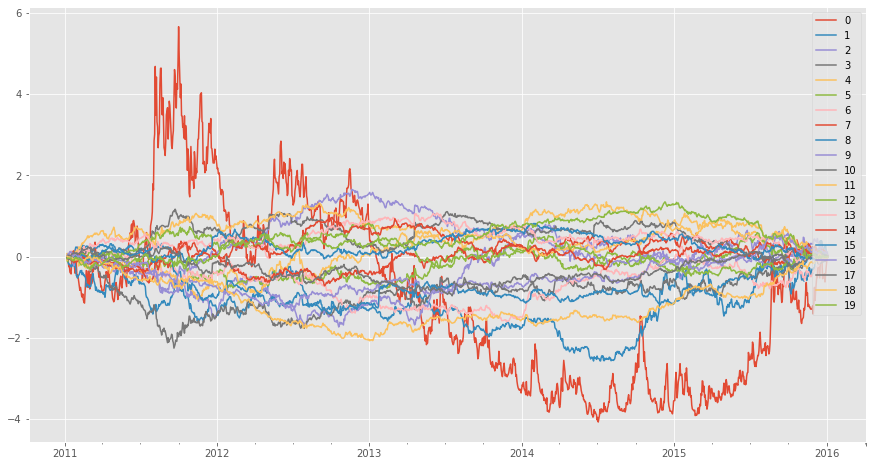

In [16]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=True, figsize=(15,8))

## Factor Covariance Matrix

In [17]:
def factor_cov_matrix(factor_returns, ann_factor):
    factor_cov_matrix = np.diag(np.var(factor_returns, axis=0, ddof=1)*ann_factor)
    
    return factor_cov_matrix


In [18]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[14.01830425,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.10591127,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.77099145,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.61798821,  0.        ,
         0.        ,  0.        ,  0.        ,  

## Idiosyncratic Variance Matrix

In [19]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    _common_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    _residuals = (returns - _common_returns)
    idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(_residuals)*ann_factor), returns.columns, returns.columns)
    
    return idiosyncratic_var_matrix


In [20]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.02272535,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AAL]),0.00000000,0.05190083,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(2 [AAP]),0.00000000,0.00000000,0.05431181,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.00000000,0.04801884,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.00000000,0.03040361,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(5 [ABC]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01854504,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(6 [ABT]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01481514,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(7 [ACN]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02177470,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(8 [ADBE]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03442125,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(9 [ADI]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01898404,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Idiosyncratic Variance Vector

In [21]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    idiosyncratic_var_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix), returns.columns)
    
    return idiosyncratic_var_vector

In [22]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(0 [A]),0.02272535
Equity(1 [AAL]),0.05190083
Equity(2 [AAP]),0.05431181
Equity(3 [AAPL]),0.04801884
Equity(4 [ABBV]),0.03040361
Equity(5 [ABC]),0.01854504
Equity(6 [ABT]),0.01481514
Equity(7 [ACN]),0.02177470
Equity(8 [ADBE]),0.03442125
Equity(9 [ADI]),0.01898404


## Predict Portfolio Risk
The formula is $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [23]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    predicted_portfolio_risk = np.sqrt(weights.T.dot(factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix).dot(weights))
    
    return predicted_portfolio_risk[0][0]

In [24]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.16094824687040468

# Alpha Factors
Create the following three factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Smoothed Factor -  [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [25]:
from zipline.pipeline.factors import CustomFactor, DailyReturns, Returns, SimpleMovingAverage, AnnualizedVolatility
from zipline.pipeline.data import USEquityPricing


factor_start_date = universe_end_date - pd.DateOffset(years=3, days=2)
sector = helper.Sector()

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor
    """
    unsmoothed_factor = -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length) \
        .rank() \
        .zscore()

class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]
        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    unsmoothed_factor = TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

In [26]:
# Add alpha factors to the pipeline
pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(20, universe, sector),
    'Mean_Reversion_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment_smoothed(2, 10, universe),
    'Overnight_Sentiment_Smoothed')

In [27]:
# Check factors
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                  -0.26276899   
                          Equity(1 [AAL])                                 0.09992624   
                          Equity(2 [AAP])                                 1.66913824   
                          Equity(3 [AAPL])                                1.69874602   
                          Equity(4 [ABBV])                                       nan   
                          Equity(5 [ABC])                                -1.11399249   
                          Equity(6 [ABT])                                 0.44041563   
                          Equity(7 [ACN])                                 0.95855167   
                          Equity(8 [ADBE])                               -1.45448188   
                          Equity(9 [ADI])                                 0.52183701   
                          Equity(10 [ADM])                               -1.10659054   
                          Equity(11 [ADP])                                0.13693595   
                          Equity(12 [ADS])                                0.45521952   
                          Equity(13 [ADSK])                              -1.44707994   
                          Equity(14 [AEE])                               -0.24056316   
                          Equity(15 [AEP])                               -0.56624867   
                          Equity(16 [AES])                               -1.38046245   
                          Equity(17 [AET])                               -1.42487411   
                          Equity(18 [AFL])                               -0.64767005   
                          Equity(19 [AGN])                               -0.27757288   
                          Equity(20 [AIG])                               -1.40266828   
                          Equity(21 [AIV])                               -0.34419037   
                          Equity(22 [AIZ])                                1.32864884   
                          Equity(23 [AJG])                                1.32124690   
                          Equity(24 [AKAM])                              -1.15840415   
                          Equity(25 [ALB])                               -1.33605079   
                          Equity(26 [ALGN])                               0.44781758   
                          Equity(27 [ALK])                               -0.06291652   
                          Equity(28 [ALL])                               -0.01110292   
                          Equity(30 [ALXN])                               0.33678843   
...                                                                              ...   
2016-01-05 00:00:00+00:00 Equity(460 [VRSN])                             -0.53814861   
                          Equity(461 [VRTX])                              0.93017740   
                          Equity(462 [VTR])                              -1.36497297   
                          Equity(463 [VZ])                               -0.15324762   
                          Equity(464 [WAT])                               0.08196966   
                          Equity(465 [WBA])                               0.05345847   
                          Equity(466 [WDC])                               0.86602724   
                          Equity(467 [WEC])                              -0.77336589   
                          Equity(468 [WFC])                              -0.47399845   
                          Equity(469 [WHR])                               1.05847773   
                          Equity(471 [WM])                               -0.83038826   
                          Equity(472 [WMB])                               1.69997939   
                          Equity(473 [WMT])                              -0.18888660   
                          Equity(474 [WRK])                               1.55029567  

## Features and Labels
### "Universal" Quant Features
Features to capture the universe
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

In [28]:
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')
pipeline.add(sector, 'sector_code')

### Regime Features
Features to capture market-wide regimes.
- High and low volatility 20d, 120d
- High and low dispersion 20d, 120d

In [29]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))


pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')

In [30]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))


pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

### Target
Predict go forward 1-week return. Create the trailing 5-day return as a quantized target factor.

In [31]:
pipeline.add(Returns(window_length=5, mask=universe).quantiles(2), 'return_5d')
pipeline.add(Returns(window_length=5, mask=universe).quantiles(25), 'return_5d_p')

### Date Features
Make columns for the trees to split on that might capture trader/investor behavior due to calendar anomalies.

In [32]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors['is_Janaury'] = all_factors.index.get_level_values(0).month == 1
all_factors['is_December'] = all_factors.index.get_level_values(0).month == 12
all_factors['weekday'] = all_factors.index.get_level_values(0).weekday
all_factors['quarter'] = all_factors.index.get_level_values(0).quarter
all_factors['qtr_yr'] = all_factors.quarter.astype('str') + '_' + all_factors.index.get_level_values(0).year.astype('str')
all_factors['month_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BM'))
all_factors['month_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BMS'))
all_factors['qtr_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQ'))
all_factors['qtr_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQS'))

print("all_factors: ", all_factors.shape)
all_factors.head()


all_factors:  (363734, 23)


Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                -0.26276899   
                          Equity(1 [AAL])                               0.09992624   
                          Equity(2 [AAP])                               1.66913824   
                          Equity(3 [AAPL])                              1.69874602   
                          Equity(4 [ABBV])                                     nan   

                                            Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])      -1.20797813   
                          Equity(1 [AAL])     1.71347052   
                          Equity(2 [AAP])    -1.53506144   
                          Equity(3 [AAPL])    1.19311071   
                          Equity(4 [ABBV])           nan   

                                            Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                      -1.48566901   
                          Equity(1 [AAL])                     0.91934963   
                          Equity(2 [AAP])                     1.50773340   
                          Equity(3 [AAPL])                   -1.36799226   
                          Equity(4 [ABBV])                   -0.25006310   

                                              adv_120d     adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     1.33857307  1.39741144   
                          Equity(1 [AAL])   1.13999355  1.08115517   
                          Equity(2 [AAP])  -0.30154668 -0.91934963   
                          Equity(3 [AAPL])  1.72837731  1.72837731   
                          Equity(4 [ABBV]) -1.72837731 -1.64747455   

                                            dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.01326964      0.01117804   
                          Equity(1 [AAL])        0.01326964      0.01117804   
                          Equity(2 [AAP])        0.01326964      0.01117804   
                          Equity(3 [AAPL])       0.01326964      0.01117804   
                          Equity(4 [ABBV])       0.01459524      0.01459524   

                                            market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.12966421      0.13758558   
                          Equity(1 [AAL])        0.12966421      0.13758558   
                          Equity(2 [AAP])        0.12966421      0.13758558   
                          Equity(3 [AAPL])       0.12966421      0.13758558   
                          Equity(4 [ABBV])       0.12966421      0.13758558   

                                            return_5d    ...      \
2013-01-03 00:00:00+00:00 Equity(0 [A])             0    ...       
                          Equity(1 [AAL])           1    ...       
                          Equity(2 [AAP])           0    ...       
                          Equity(3 [AAPL])          1    ...       
                          Equity(4 [ABBV])         -1    ...       

                                            volatility_20d  is_Janaury  \
2013-01-03 00:00:00+00:00 Equity(0 [A])        -1.21980876        True   
                          Equity(1 [AAL])       1.56621970        True   
                          Equity(2 [AAP])      -1.47040391        True   
                          Equity(3 [AAPL])      1.61781282        True   
                          Equity(4 [ABBV])             nan        True   

                                            is_December  weekday  quarter  \
2013-01-03 00:00:00+00:00 Equity(0 [A])           False        3        1   
                          Equity(1 [AAL])         False        3        1   
                          Equity(2 [AAP])         False        3        1   
                          Equity(3 [AAPL])        False        3        1   
                          Equity(4 [ABBV])        False        3        1   

                     

### One Hot Encode Sectors
For the model to better understand the sector data

In [33]:
all_factors['sector_code'].head()

2013-01-03 00:00:00+00:00  Equity(0 [A])       0
                           Equity(1 [AAL])     3
                           Equity(2 [AAP])     8
                           Equity(3 [AAPL])    1
                           Equity(4 [ABBV])    0
Name: sector_code, dtype: int64

In [34]:
sector_lookup = pd.read_csv('./data/sector/labels.csv', index_col='Sector_i')['Sector'].to_dict()
sector_lookup

{0: 'Healthcare',
 1: 'Technology',
 2: 'Consumer Defensive',
 3: 'Industrials',
 4: 'Utilities',
 5: 'Financial Services',
 6: 'Real Estate',
 7: 'Communication Services',
 8: 'Consumer Cyclical',
 9: 'Energy',
 10: 'Basic Materials'}

In [35]:
sector_columns = []
for sector_i, sector_name in sector_lookup.items():
    secotr_column = 'sector_{}'.format(sector_name)
    sector_columns.append(secotr_column)
    all_factors[secotr_column] = (all_factors['sector_code'] == sector_i)

all_factors[sector_columns].head()

sector_Healthcare  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                  True   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(4 [ABBV])               True   

                                            sector_Technology  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])               True   
                          Equity(4 [ABBV])              False   

                                            sector_Consumer Defensive  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                         False   
                          Equity(1 [AAL])                       False   
                          Equity(2 [AAP])                       False   
                          Equity(3 [AAPL])                      False   
                          Equity(4 [ABBV])                      False   

                                            sector_Industrials  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                  False   
                          Equity(1 [AAL])                 True   
                          Equity(2 [AAP])                False   
                          Equity(3 [AAPL])               False   
                          Equity(4 [ABBV])               False   

                                            sector_Utilities  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])             False   
                          Equity(4 [ABBV])             False   

                                            sector_Financial Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                         False   
                          Equity(1 [AAL])                       False   
                          Equity(2 [AAP])                       False   
                          Equity(3 [AAPL])                      False   
                          Equity(4 [ABBV])                      False   

                                            sector_Real Estate  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                  False   
                          Equity(1 [AAL])                False   
                          Equity(2 [AAP])                False   
                          Equity(3 [AAPL])               False   
                          Equity(4 [ABBV])               False   

                                            sector_Communication Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                             False   
                          Equity(1 [AAL])                           False   
                          Equity(2 [AAP])                           False   
                          Equity(3 [AAPL])                          False   
                          Equity(4 [ABBV])                          False   

                                            sector_Consumer Cyclical  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                       True   
                          Equity(3 [AAPL])                     False   
                          Equity(4 [ABBV])                     False   

                                            sector_Energy  \
2013-01-03 00:00:00+00:00 Equity(0 [A])             False   
                          Equity(1 [AAL])           False   
                          Equity(2 [AAP])           False   
                          Equity(3 [AAPL])          False   
    

### Shift Target
Shifted 5 day returns for training the model

In [36]:
all_factors['target'] = all_factors.groupby(level=1)['return_5d'].shift(-5)
all_factors[['return_5d','target']].reset_index().sort_values(['level_1', 'level_0']).head(10)

,level_0,level_1,return_5d,target
0,2013-01-03 00:00:00+00:00,Equity(0 [A]),0,0.00000000
471,2013-01-04 00:00:00+00:00,Equity(0 [A]),0,0.00000000
942,2013-01-07 00:00:00+00:00,Equity(0 [A]),0,0.00000000
1413,2013-01-08 00:00:00+00:00,Equity(0 [A]),0,1.00000000
1884,2013-01-09 00:00:00+00:00,Equity(0 [A]),0,0.00000000
2355,2013-01-10 00:00:00+00:00,Equity(0 [A]),0,0.00000000
2826,2013-01-11 00:00:00+00:00,Equity(0 [A]),0,0.00000000
3297,2013-01-14 00:00:00+00:00,Equity(0 [A]),0,0.00000000
3768,2013-01-15 00:00:00+00:00,Equity(0 [A]),1,0.00000000
4239,2013-01-16 00:00:00+00:00,Equity(0 [A]),0,0.00000000


### IID Check of Target
Check if the returns are independent and identically distributed.

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


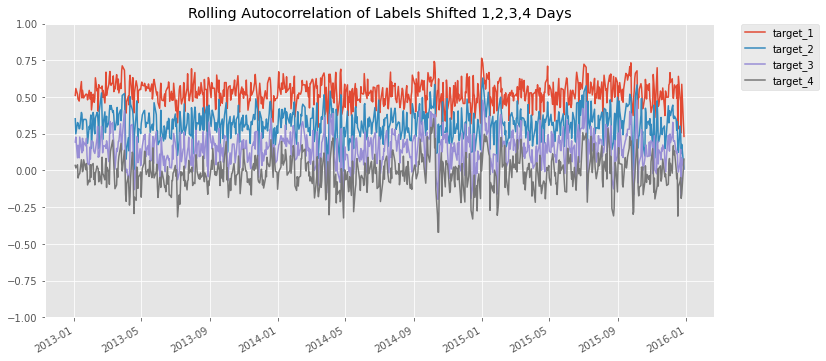

In [37]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]

all_factors['target_p'] = all_factors.groupby(level=1)['return_5d_p'].shift(-5)
all_factors['target_1'] = all_factors.groupby(level=1)['return_5d'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level=1)['return_5d'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level=1)['return_5d'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level=1)['return_5d'].shift(-1)

g = all_factors.dropna().groupby(level=0)

plt.figure(figsize=(12,6))
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
    
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

### Train/Valid/Test Splits
When splitting, make sure the data is in order from train, validation, and test respectivly. Say `train_size` is 0.7, `valid_size` is 0.2, and `test_size` is 0.1. The first 70 percent of `all_x` and `all_y` would be the train set. The next 20 percent of `all_x` and `all_y` would be the validation set. The last 10 percent of `all_x` and `all_y` would be the test set. Make sure not split a day between multiple datasets. It should be contained within a single dataset.

In [38]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    # TODO: Implement
    train_size_loc = int(all_x.shape[0]*train_size)
    valid_size_loc = int(all_x.shape[0]*valid_size) + train_size_loc
    
    x_train = all_x[:train_size_loc]
    x_valid = all_x[train_size_loc:valid_size_loc]
    x_test = all_x[valid_size_loc:]
    y_train = all_y[:train_size_loc]
    y_valid = all_y[train_size_loc:valid_size_loc]
    y_test = all_y[valid_size_loc:]
        
    return x_train, x_valid, x_test, y_train, y_valid, y_test


unit_test.test_train_valid_test_split(train_valid_test_split)

Tests Passed


In [39]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_Janaury', 'is_December', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                -0.26276899   
                          Equity(1 [AAL])                               0.09992624   
                          Equity(2 [AAP])                               1.66913824   
                          Equity(3 [AAPL])                              1.69874602   
                          Equity(5 [ABC])                              -1.11399249   

                                            Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])      -1.20797813   
                          Equity(1 [AAL])     1.71347052   
                          Equity(2 [AAP])    -1.53506144   
                          Equity(3 [AAPL])    1.19311071   
                          Equity(5 [ABC])    -0.50920924   

                                            Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                      -1.48566901   
                          Equity(1 [AAL])                     0.91934963   
                          Equity(2 [AAP])                     1.50773340   
                          Equity(3 [AAPL])                   -1.36799226   
                          Equity(5 [ABC])                    -0.02941919   

                                              adv_120d     adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     1.33857307  1.39741144   
                          Equity(1 [AAL])   1.13999355  1.08115517   
                          Equity(2 [AAP])  -0.30154668 -0.91934963   
                          Equity(3 [AAPL])  1.72837731  1.72837731   
                          Equity(5 [ABC])   0.17651513  0.22799871   

                                            dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.01326964      0.01117804   
                          Equity(1 [AAL])        0.01326964      0.01117804   
                          Equity(2 [AAP])        0.01326964      0.01117804   
                          Equity(3 [AAPL])       0.01326964      0.01117804   
                          Equity(5 [ABC])        0.01326964      0.01117804   

                                            market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.12966421      0.13758558   
                          Equity(1 [AAL])        0.12966421      0.13758558   
                          Equity(2 [AAP])        0.12966421      0.13758558   
                          Equity(3 [AAPL])       0.12966421      0.13758558   
                          Equity(5 [ABC])        0.12966421      0.13758558   

                                            volatility_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])        -1.21980876   
                          Equity(1 [AAL])       1.56621970   
                          Equity(2 [AAP])      -1.47040391   
                          Equity(3 [AAPL])      1.61781282   
                          Equity(5 [ABC])      -1.36721767   

                                                     ...            \
2013-01-03 00:00:00+00:00 Equity(0 [A])              ...             
                          Equity(1 [AAL])            ...             
                          Equity(2 [AAP])            ...             
                          Equity(3 [AAPL])           ...             
                          Equity(5 [ABC])            ...             

                                            sector_Technology  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])               True   
                          Equity(5 [ABC])               False   

                                            sector_Consumer Defensive  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                         False   
       

## Random Forests
### Visualize a Tree

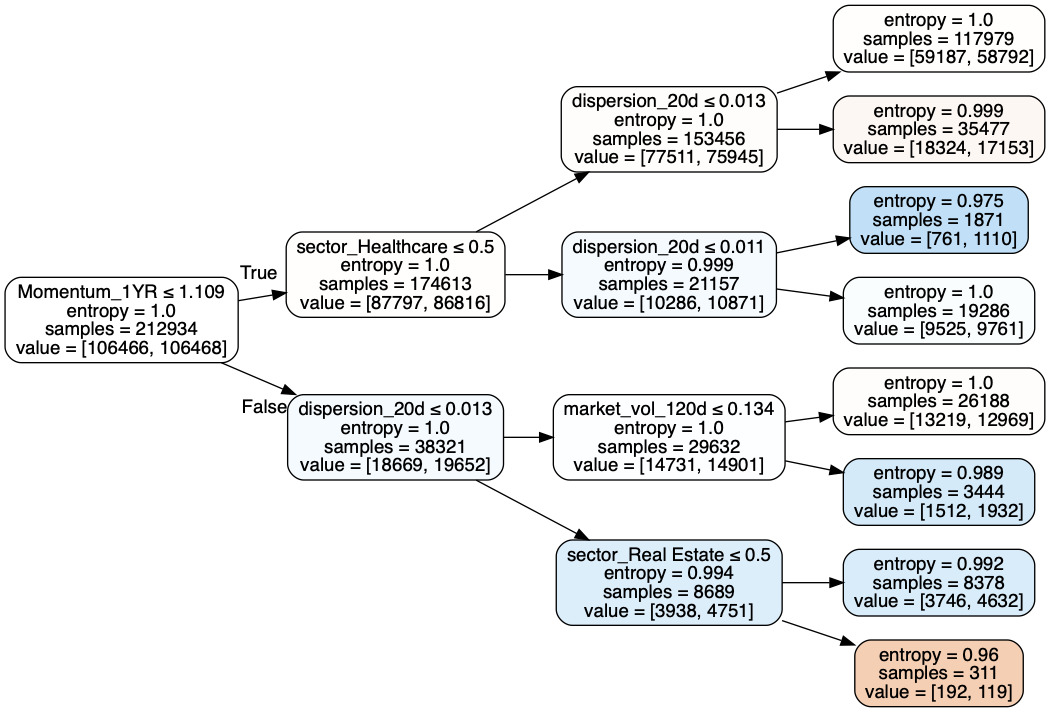

      Feature                                    Importance
 1. dispersion_20d                         (0.4689065622873918)
 2. market_vol_120d                        (0.19307524853086544)
 3. sector_Real Estate                     (0.12804098739290343)
 4. Momentum_1YR                           (0.11245888333225494)
 5. sector_Healthcare                      (0.09751831845658443)
 6. sector_Basic Materials                 (0.0)
 7. weekday                                (0.0)
 8. Overnight_Sentiment_Smoothed           (0.0)
 9. adv_120d                               (0.0)
10. adv_20d                                (0.0)
11. dispersion_120d                        (0.0)
12. market_vol_20d                         (0.0)
13. volatility_20d                         (0.0)
14. is_Janaury                             (0.0)
15. is_December                            (0.0)
16. month_end                              (0.0)
17. sector_Energy                          (0.0)
18. month_start             

In [40]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier

# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)
simple_clf.fit(X_train, y_train)

display(helper.plot_tree_classifier(simple_clf, feature_names=features))
helper.rank_features_by_importance(simple_clf.feature_importances_, features)

### Train Random Forests with Different Tree Sizes
#### Parameters
min_samples_leaf parameter to be small enough to allow the tree to fit the data with as much detail as possible, but not so much that it overfits.
Since we have about 500 stocks in the stock universe, we’ll want at least 500 stocks in a leaf for the leaf to make a prediction that is representative. It’s common to multiply this by 2,3,5 or 10, so we’d have min samples leaf of 500, 1000, 1500, 2500, and 5000. 
If sharpe ratio is greater than 4, it would be a sign of “too good to be true”.

In [41]:
n_days = 10
n_stocks = 500

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 500, 1000]

#### Train the model

In [42]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [01:36<00:00, 19.38s/Model]


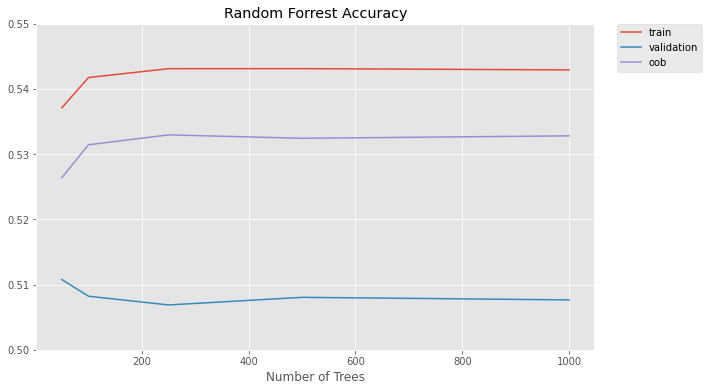

In [43]:
plt.figure(figsize=(10,6))
helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [44]:
print('Features Ranked by Average Importance:\n')
helper.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                    Importance
 1. dispersion_20d                         (0.1272818548794445)
 2. volatility_20d                         (0.12242735570876113)
 3. market_vol_120d                        (0.10513743366026759)
 4. market_vol_20d                         (0.1038189778654078)
 5. Momentum_1YR                           (0.09457977425615909)
 6. dispersion_120d                        (0.08005632079067652)
 7. Overnight_Sentiment_Smoothed           (0.07744097747708331)
 8. Mean_Reversion_Sector_Neutral_Smoothed (0.06912219864639728)
 9. adv_120d                               (0.0599502823871783)
10. adv_20d                                (0.05456174767332596)
11. sector_Healthcare                      (0.03165203966535734)
12. sector_Basic Materials                 (0.012388131735165831)
13. sector_Consumer Defensive              (0.011213976999730837)
14. sector_Industrials                     (0.0106706560

### Model Results
Analyze the followings.
#### Sharpe Ratio
Target Range: 1.5 - 2.0
Below 1.0 is not a good alpha. Above 4.0 is too good to be true.

#### Factor Returns
Cumulative factor return should move up and to the right.

#### Basis Points of Factor Returns per Day per Quantile
A good alpha is also monotonic in quantiles.

#### Turnover Analysis
Factor Rank Autocorrelation to see how stable the alphas are over time before full backtest.

In [45]:
import helper

In [46]:
import alphalens as al

all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

def plot_factor_returns(factor_returns):
    (1 + factor_returns).cumprod().plot(ylim=(0.9, 1.5), figsize=(12,7))
    
def plot_qr_factor_returns(qr_factor_returns):
    (10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)
    
    
def plot_factor_rank_autocorrelation(factor_data):
    ls_FRA = pd.DataFrame()

    unixt_factor_data = {
        factor: factor_data.set_index(pd.MultiIndex.from_tuples(
            [(x.timestamp(), y) for x, y in factor_data.index.values],
            names=['date', 'asset']))
        for factor, factor_data in factor_data.items()}

    for factor, factor_data in unixt_factor_data.items():
        ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

    ls_FRA.plot(title="Factor Rank Autocorrelation", ylim=(0.8, 1.0), figsize=(12,7))
    
def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = helper.get_factor_returns(factor_data)
    qr_factor_returns = helper.get_qr_factor_returns(factor_data)
    sharpe_ratio = helper.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    plot_factor_returns(factor_returns)
    plot_qr_factor_returns(qr_factor_returns)
    plot_factor_rank_autocorrelation(factor_data)

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'adv_120d',
    'volatility_20d']

#### Training

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuki/miniconda3/envs/ai-a

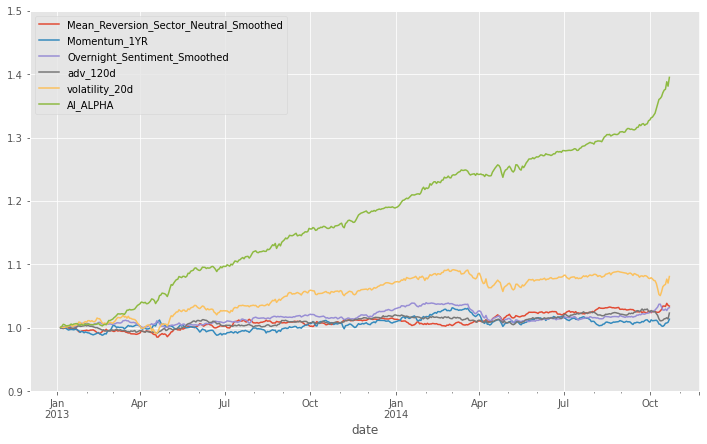

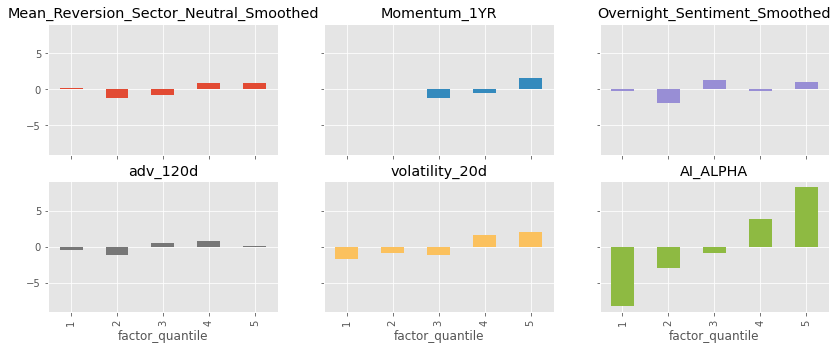

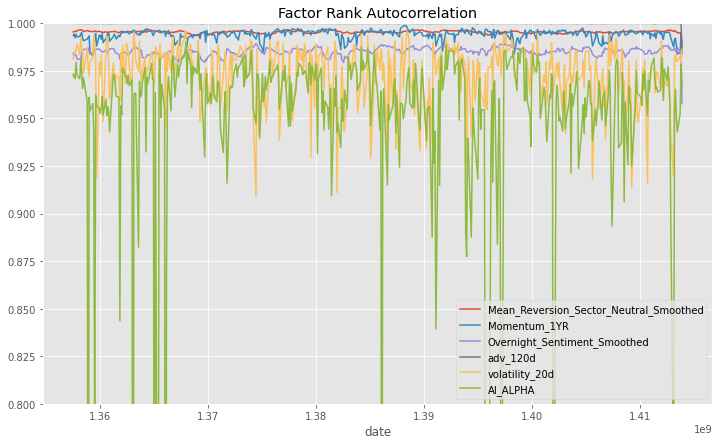

In [48]:
show_sample_results(all_factors, X_train, clf, factor_names)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuki/miniconda3/envs/ai-a

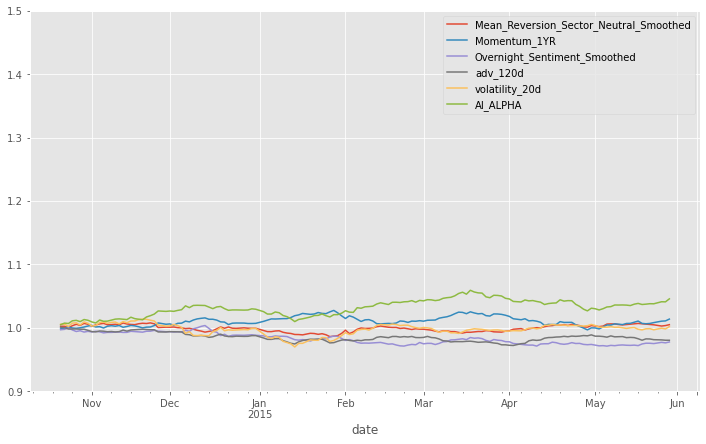

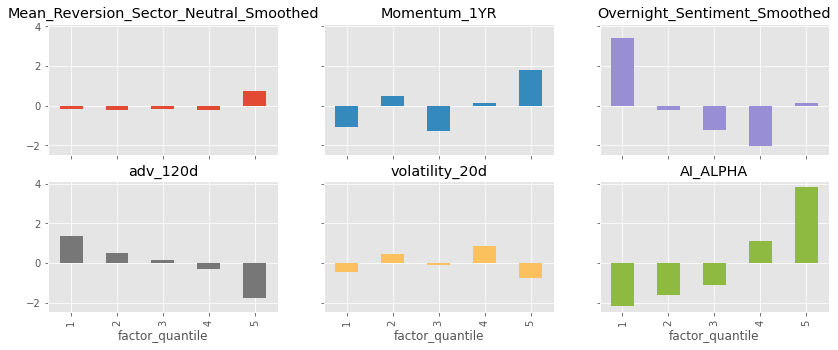

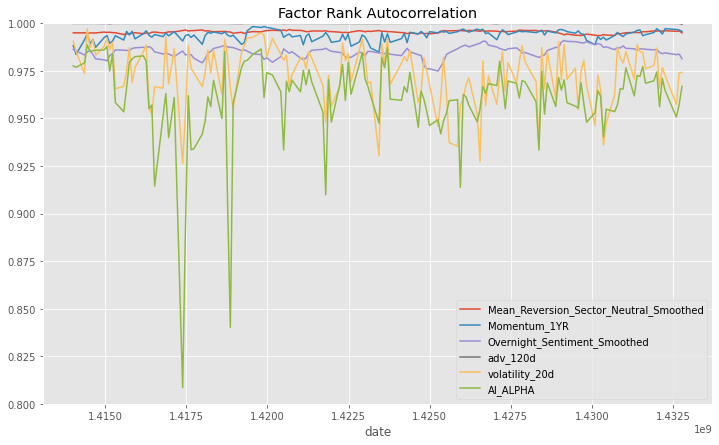

In [49]:
show_sample_results(all_factors, X_valid, clf, factor_names)

## Ensemble of non-overlapping trees
To see actual performance in production, correct overlapping samples for the non-IID labels and mitigate likely overfitting.

In [50]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

def calculate_oob_score(classifiers):
    '''
    Calculate the mean out-of-bag score from the classifiers.
    '''
    oob_score = 0
    for clf in classifiers:
        oob_score += clf.oob_score_ 
    return oob_score / len(classifiers)

def non_overlapping_estimators(x, y, classifiers, n_skip_samples):
    '''
    Fit the classifiers to non overlapping data.

    Parameters
    ----------
    x : [DataFrame] The input samples
    y : [Pandas Series] The target values
    '''
    fit_classifiers = []
    
    for i in range(n_skip_samples):
        fit_classifiers.append(
            classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
        )

    return fit_classifiers

class NoOverlapVoter(NoOverlapVoterAbstract):
    def _calculate_oob_score(self, classifiers):
        return calculate_oob_score(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        return non_overlapping_estimators(x, y, classifiers, n_skip_samples)
    

### Train the model

In [51]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models:   0%|          | 0/5 [00:00<?, ?Model/s]/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
Training Models:  20%|██        | 1/5 [00:04<00:16,  4.11s/Model]/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not

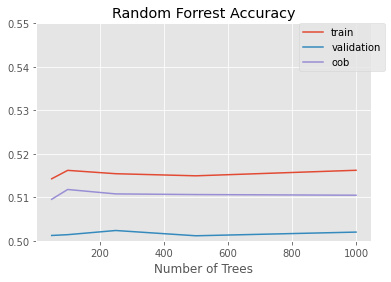

In [52]:
helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

### 

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuki/miniconda3/envs/ai-a

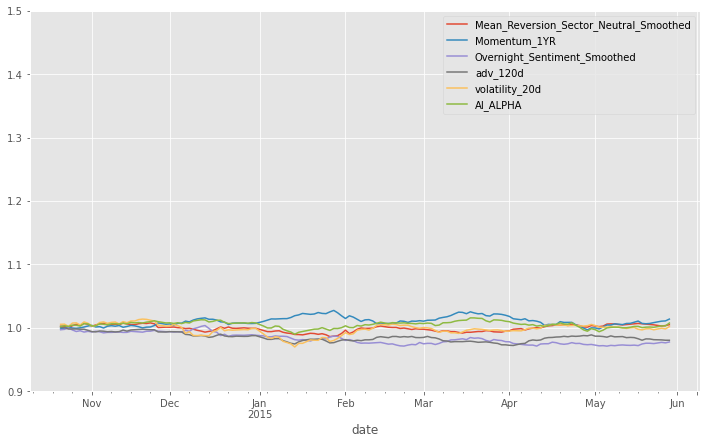

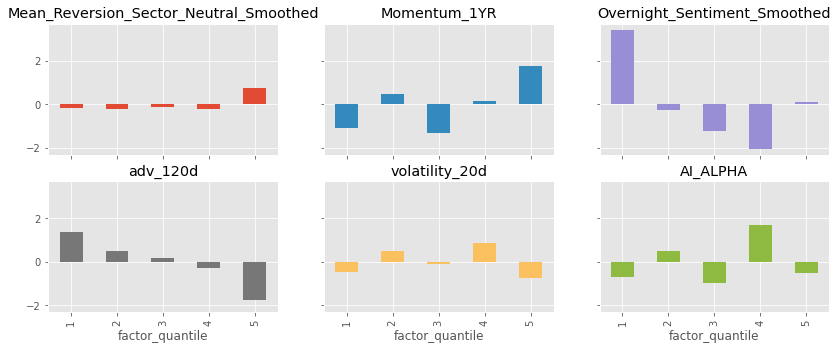

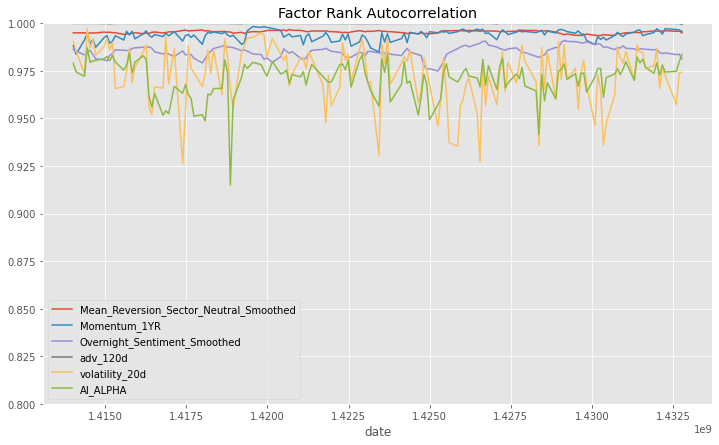

In [53]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Re-Training
Roll forward the training to "current day" in production, so re-train the model on train & validation dataset here.

In [54]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None, n_skip_samples=4, voting='soft')

In [55]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


train: 0.5172072097457429, oob: 0.5224717518104202, valid: 0.5125214855307278


/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuki/miniconda3/envs/ai-a

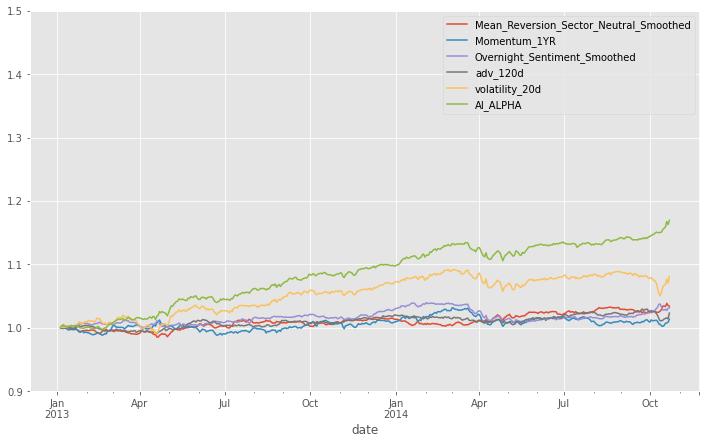

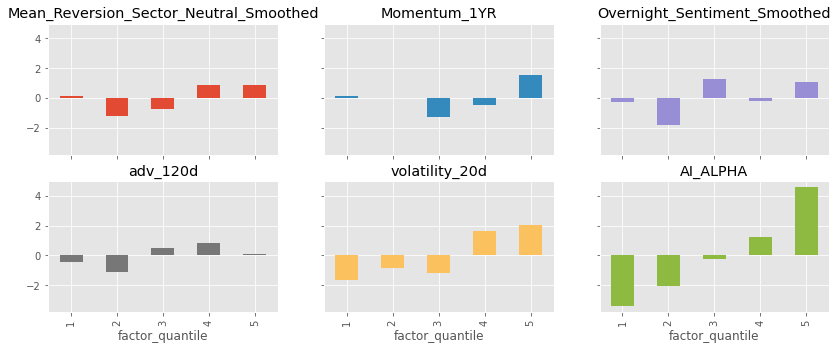

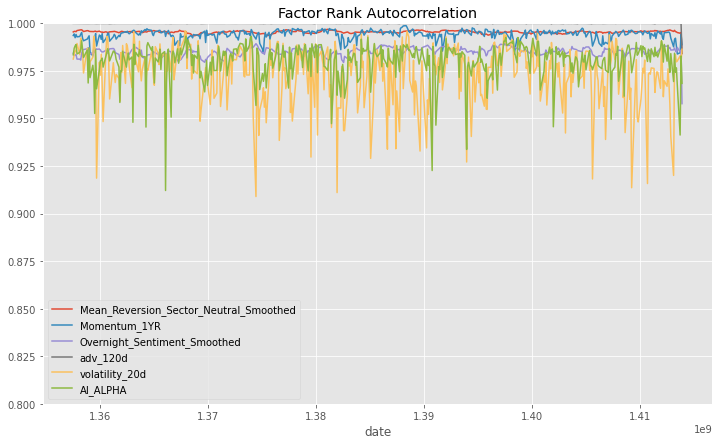

In [56]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuki/miniconda3/envs/ai-a

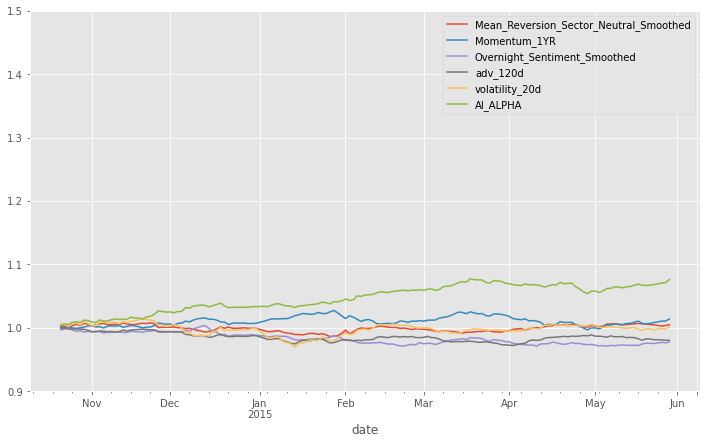

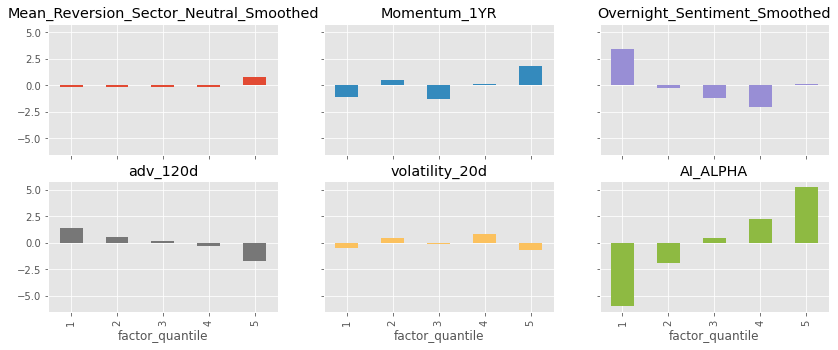

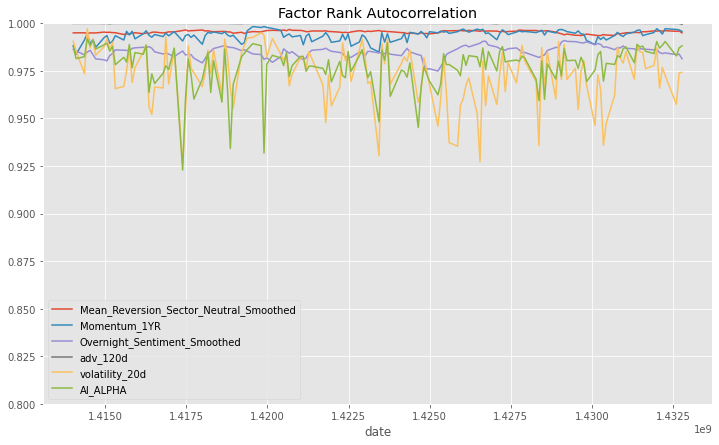

In [57]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuki/miniconda3/envs/ai-a

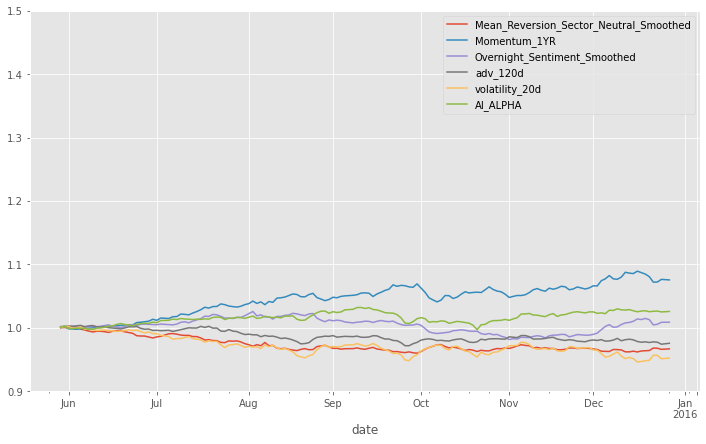

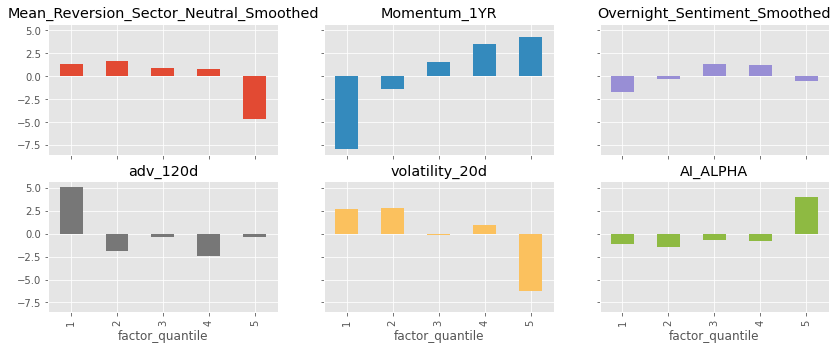

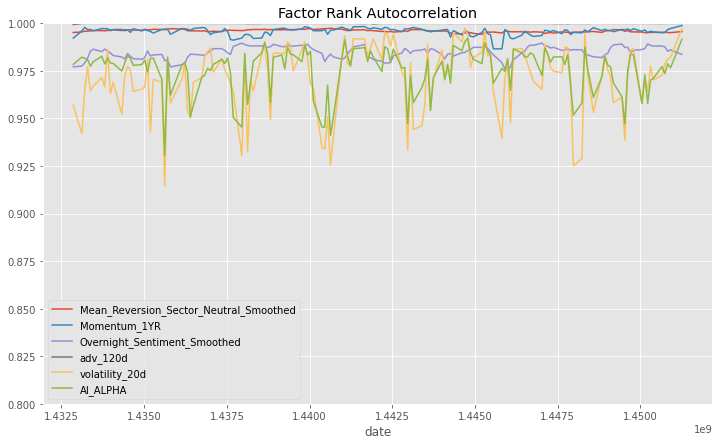

In [58]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

## Alpha Vector

In [67]:
alphas = clf_nov.predict_proba(X).dot(np.array([-1,1]))
alphas

array([-0.00835599,  0.00377767, -0.00253571, ..., -0.00534459,
        0.00774959, -0.00510423])

In [77]:
alpha_score_label = 'AI_ALPHA'
factors_with_alpha = X.copy()
factors_with_alpha[alpha_score_label] = alphas
factors_with_alpha

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                  -0.26276899   
                          Equity(1 [AAL])                                 0.09992624   
                          Equity(2 [AAP])                                 1.66913824   
                          Equity(3 [AAPL])                                1.69874602   
                          Equity(5 [ABC])                                -1.11399249   
                          Equity(6 [ABT])                                 0.44041563   
                          Equity(7 [ACN])                                 0.95855167   
                          Equity(8 [ADBE])                               -1.45448188   
                          Equity(9 [ADI])                                 0.52183701   
                          Equity(10 [ADM])                               -1.10659054   
                          Equity(11 [ADP])                                0.13693595   
                          Equity(12 [ADS])                                0.45521952   
                          Equity(13 [ADSK])                              -1.44707994   
                          Equity(14 [AEE])                               -0.24056316   
                          Equity(15 [AEP])                               -0.56624867   
                          Equity(16 [AES])                               -1.38046245   
                          Equity(17 [AET])                               -1.42487411   
                          Equity(18 [AFL])                               -0.64767005   
                          Equity(19 [AGN])                               -0.27757288   
                          Equity(20 [AIG])                               -1.40266828   
                          Equity(21 [AIV])                               -0.34419037   
                          Equity(22 [AIZ])                                1.32864884   
                          Equity(23 [AJG])                                1.32124690   
                          Equity(24 [AKAM])                              -1.15840415   
                          Equity(25 [ALB])                               -1.33605079   
                          Equity(26 [ALGN])                               0.44781758   
                          Equity(27 [ALK])                               -0.06291652   
                          Equity(28 [ALL])                               -0.01110292   
                          Equity(30 [ALXN])                               0.33678843   
                          Equity(31 [AMAT])                              -0.38860203   
...                                                                              ...   
2015-12-28 00:00:00+00:00 Equity(459 [VRSK])                             -1.65705832   
                          Equity(460 [VRSN])                             -1.29993368   
                          Equity(461 [VRTX])                              0.47854701   
                          Equity(462 [VTR])                              -1.11422887   
                          Equity(463 [VZ])                               -0.41426458   
                          Equity(464 [WAT])                               0.23570226   
                          Equity(465 [WBA])                               0.64996684   
                          Equity(466 [WDC])                               1.14994133   
                          Equity(467 [WEC])                              -0.42854956   
                          Equity(468 [WFC])                              -0.23570226   
                          Equity(469 [WHR])                               0.50711698   
                          Equity(471 [WM])                               -0.25712974   
                          Equity(472 [WMB])                               1.64277333   
                          Equity(473 [WMT])                              -0.01428499  

## Optimal Portfolio Constrained by Risk Model
AI_ALPHA looks promising, so find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.

In [59]:
from abc import ABC, abstractmethod

class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints

### Objective Function
Maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

### Constraints
The first constraint is that the predicted risk be less than some maximum limit. 
- $ r \leq risk_{\text{cap}}^2 \\ $

The second and third constraints are on the maximum and minimum portfolio factor exposures. 
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $

The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. 
- $ x^T\mathbb{1} = 0 \\ $

The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. 
- $ \|x\|_1 \leq 1 \\ $

The last are some minimum and maximum limits on individual holdings.
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk



In [60]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        assert(len(alpha_vector.columns) == 1)
        objective = cvx.Minimize(-alpha_vector.values.flatten()*weights)
        
        return objective
    
    def _get_constraints(self, weights, factor_betas, risk):

        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        constraints = [
        risk <= self.risk_cap ** 2,   
        factor_betas.T*weights <= self.factor_max,
        factor_betas.T*weights >= self.factor_min,
        sum(weights) == 0.0,
        sum(cvx.abs(weights)) <= 1.0,
        weights >= self.weights_min,
        weights <= self.weights_max        
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

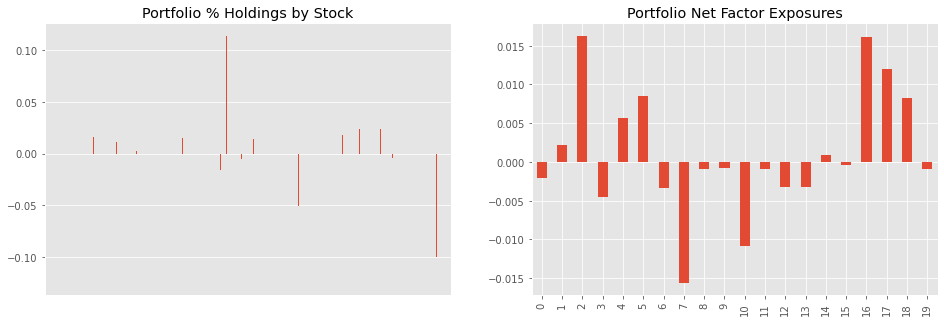

In [93]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock', ax=ax1)
ax1.axes.xaxis.set_visible(False)
helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False, ax=ax2)

## Optimize with a Regularization Parameter
In order to enforce diversification, use regularization in the objective function. 

Maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

In [83]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        objective = cvx.Minimize(-alpha_vector.values.flatten()*weights + self.lambda_reg*cvx.norm(weights,2))
        
        return objective

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

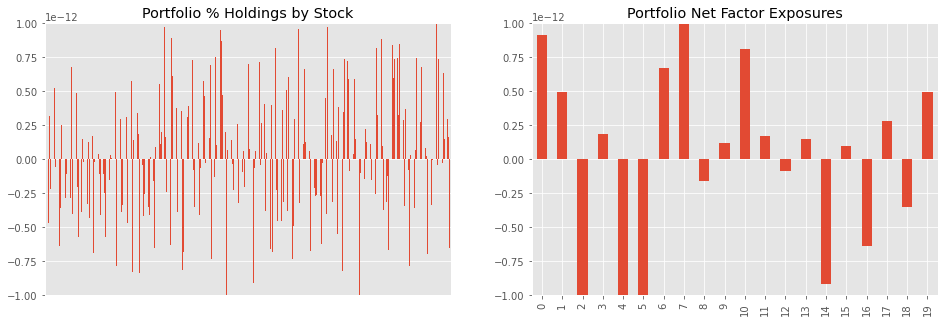

In [94]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock', ax=ax1)
ax1.axes.xaxis.set_visible(False)
helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures', legend=False, ax=ax2)

## Optimize for Target Weight
Minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting, while respecting portfolio-level constraints. 

In [89]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        objective = cvx.Minimize(cvx.norm(alpha_vector.values.flatten()-weights,2))
        
        return objective


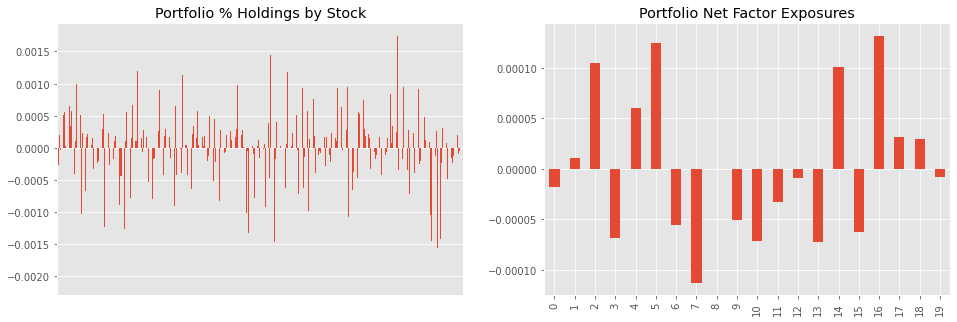

In [95]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock', ax=ax1)
ax1.axes.xaxis.set_visible(False)

helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures', legend=False, ax=ax2)

In [97]:
optimal_weights_2

,0
Equity(0 [A]),0.00092120
Equity(1 [AAL]),-0.00026314
Equity(2 [AAP]),0.00019966
Equity(3 [AAPL]),-0.00003172
Equity(4 [ABBV]),0.00034829
Equity(5 [ABC]),-0.00032520
Equity(6 [ABT]),0.00058040
Equity(7 [ACN]),0.00050638
Equity(8 [ADBE]),0.00055380
Equity(9 [ADI]),0.00003647
